<a href="https://colab.research.google.com/github/eevvvaa/Deep_Generative_Model-HW/blob/main/4112029030_%E4%BD%BF%E7%94%A8%E8%AE%8A%E5%88%86%E8%87%AA%E7%B7%A8%E7%A2%BC%E5%99%A8%EF%BC%88VAE%EF%BC%89%E9%87%8D%E5%BB%BA_MNIST_%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import files
uploaded = files.upload()  # 選取四個檔案上傳到 /content

Saving t10k-images-idx3-ubyte.gz to t10k-images-idx3-ubyte.gz
Saving t10k-labels-idx1-ubyte.gz to t10k-labels-idx1-ubyte.gz
Saving train-images-idx3-ubyte.gz to train-images-idx3-ubyte.gz
Saving train-labels-idx1-ubyte.gz to train-labels-idx1-ubyte.gz


Epoch 1, Average loss: 162.1472
Epoch 2, Average loss: 120.6750
Epoch 3, Average loss: 114.3850
Epoch 4, Average loss: 111.6139
Epoch 5, Average loss: 109.9251
訓練完成！
已儲存重建圖檔 reconstruction.png


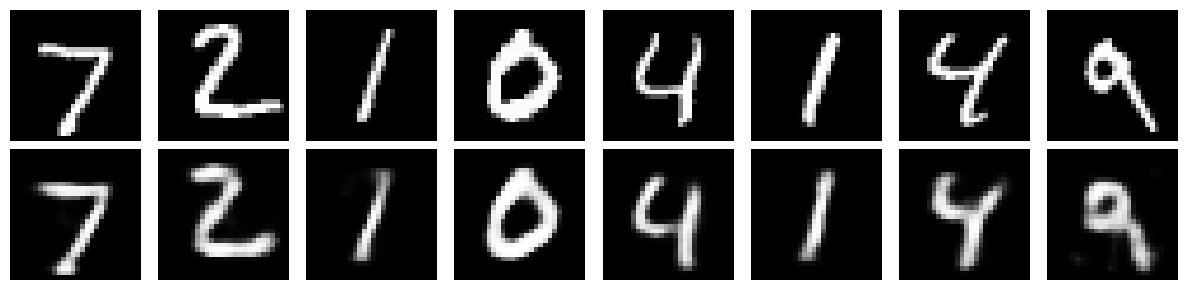

In [15]:
import gzip
import numpy as np
import struct
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import os

# ========== 讀取本機 MNIST 資料 ==========
def load_images(file_path, num_samples):
    with gzip.open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        if magic != 2051:
            raise ValueError("Magic number mismatch in image file!")
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num, rows, cols) / 255.0  # normalize
        return data

def load_labels(file_path, num_samples):
    with gzip.open(file_path, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError("Magic number mismatch in label file!")
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# 設定資料夾路徑
data_dir = "/content"
train_images = load_images(os.path.join(data_dir, "train-images-idx3-ubyte.gz"), 60000)
train_labels = load_labels(os.path.join(data_dir, "train-labels-idx1-ubyte.gz"), 60000)
test_images = load_images(os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), 10000)
test_labels = load_labels(os.path.join(data_dir, "t10k-labels-idx1-ubyte.gz"), 10000)

# 轉為 tensor dataset
x_train = torch.tensor(train_images, dtype=torch.float32).view(-1, 784)
x_test = torch.tensor(test_images, dtype=torch.float32).view(-1, 784)

train_loader = DataLoader(TensorDataset(x_train), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test), batch_size=128, shuffle=False)

# ========== 模型設計：VAE ==========
latent_dim = 20

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# ========== 訓練設定 ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        data = batch[0].to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(x_train)
    print(f"Epoch {epoch+1}, Average loss: {avg_loss:.4f}")

print("訓練完成！")

# ========== 結果輸出 ==========
model.eval()
with torch.no_grad():
    data = next(iter(test_loader))[0][:8].to(device)  # 取前 8 張
    recon, _, _ = model(data)

    fig, axes = plt.subplots(2, 8, figsize=(12, 3))

    for i in range(8):
        axes[0, i].imshow(data[i].cpu().view(28, 28), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(recon[i].cpu().view(28, 28), cmap="gray")
        axes[1, i].axis("off")
    axes[0, 0].set_ylabel("Input", fontsize=10)
    axes[1, 0].set_ylabel("Reconstruction", fontsize=10)
    plt.tight_layout()
    plt.savefig("reconstruction.png")
    print("已儲存重建圖檔 reconstruction.png")
    plt.show()